In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf
import urllib.request

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import healpy as hp
from astropy.coordinates import Angle
from collections import OrderedDict

from io import BytesIO
from pathlib import Path
from skimage.transform import ProjectiveTransform, warp

from astropy.io.fits.header import Header
from collections import namedtuple


In [53]:

Shape = namedtuple('Shape', ['width', 'height'])
"""Helper for 2-dim image shape, to make it clearer what value is width and height."""


class WCSGeometry:
    """Container for WCS object and image shape.

    Parameters
    ----------
    wcs : `~astropy.wcs.WCS`
        WCS projection object
    width : int
        Width of the image in pixels
    height : int
        Height of the image in pixels

    Examples
    --------
    >>> from astropy.coordinates import SkyCoord
    >>> from hips.utils import WCSGeometry
    >>> skycoord = SkyCoord(10, 20, unit='deg')
    >>> wcs_geometry = WCSGeometry.create(
    ...     skydir=skycoord, width=20, height=10,
    ...     coordsys='CEL', projection='AIT',
    ...     cdelt=1.0, crpix=(1., 1.),
    ... )
    >>> wcs_geometry.wcs
    Number of WCS axes: 2
    CTYPE : 'RA---AIT'  'DEC--AIT'
    CRVAL : 10.0  20.0
    CRPIX : 1.0  1.0
    PC1_1 PC1_2  : 1.0  0.0
    PC2_1 PC2_2  : 0.0  1.0
    CDELT : -1.0  1.0
    NAXIS : 0  0
    >>> wcs_geometry.shape
    Shape(width=20, height=10)
    """
    WCS_ORIGIN_DEFAULT = 0
    """Default WCS transform origin, to be used in all WCS pix <-> world calls."""

    def __init__(self, wcs, width: int, height: int) -> None:
        self.wcs = wcs
        self.shape = Shape(*(width, height))

    @property
    def center_pix(self):
        """Image center in pixel coordinates (tuple of x, y)."""
        x = float(self.shape.width - 1) / 2
        y = float(self.shape.height - 1) / 2
        return x, y

    @property
    def pixel_skycoords(self) -> SkyCoord:
        """Grid of sky coordinates of the image pixels (`~astropy.coordinates.SkyCoord`)."""
        y, x = np.indices(self.shape)
        return self.pix_to_sky(x, y)

    @property
    def center_skycoord(self) -> SkyCoord:
        """Image center in sky coordinates (`~astropy.coordinates.SkyCoord`)."""
        return self.pix_to_sky(*self.center_pix)

    def pix_to_sky(self, x, y) -> SkyCoord:
        """Helper function to convert pix to sky coordinates."""
        return pixel_to_skycoord(x, y, self.wcs, self.WCS_ORIGIN_DEFAULT)

    @classmethod
    def create(cls, skydir: SkyCoord, width: int, height: int, coordsys: str = 'icrs',
               projection: str = 'AIT', cdelt: float = 1.0, crpix: tuple = (1., 1.)) -> 'WCSGeometry':
        """Create WCS object programmatically (`WCSGeometry`).

        Parameters
        ----------
        skydir : `~astropy.coordinates.SkyCoord`
            Sky coordinate of the WCS reference point
        width : `int`
            Width of the image in pixels
        height : `int`
            Height of the image in pixels
        coordsys : {'icrs', 'galactic'}
            Coordinate system
        projection : `str`
            Projection of the WCS object.
            To see list of supported projections
            visit: http://docs.astropy.org/en/stable/wcs/#supported-projections
        cdelt : `float`
            Coordinate increment at reference point
        crpix : `tuple`
            Pixel coordinates of reference point
            (WCS axis order: x, y and FITS convention origin=1)
        """
        w = WCS(naxis=2)

        if coordsys == 'icrs':
            w.wcs.ctype[0] = 'RA---'+projection
            w.wcs.ctype[1] = 'DEC--'+projection
            w.wcs.crval[0] = skydir.icrs.ra.deg
            w.wcs.crval[1] = skydir.icrs.dec.deg
        elif coordsys == 'galactic':
            w.wcs.ctype[0] = 'GLON-'+projection
            w.wcs.ctype[1] = 'GLAT-'+projection
            w.wcs.crval[0] = skydir.galactic.l.deg
            w.wcs.crval[1] = skydir.galactic.b.deg
        else:
            raise ValueError('Unrecognized coordinate system.')  # pragma: no cover

        w.wcs.crpix[0] = crpix[0]
        w.wcs.crpix[1] = crpix[1]

        w.wcs.cdelt[0] = -cdelt
        w.wcs.cdelt[1] = cdelt

        w = WCS(w.to_header())

        return cls(w, width, height)

    @classmethod
    def create_simple(cls, skydir: SkyCoord, width: int, height: int, fov: {str, Angle},
                      coordsys: str = 'icrs', projection: str = 'AIT') -> 'WCSGeometry':
        """Create WCS object programmatically using field of view (`WCSGeometry`).

        Parameters
        ----------
        skydir : `~astropy.coordinates.SkyCoord`
            Sky coordinate of the WCS reference point
        width : `int`
            Width of the image in pixels
        height : `int`
            Height of the image in pixels
        fov: `str` or Angle
            Field of view
        coordsys : {'icrs', 'galactic'}
            Coordinate system
        projection : `str`
            Projection of the WCS object.
            To see list of supported projections
            visit: http://docs.astropy.org/en/stable/wcs/#supported-projections

        Examples
        --------
        >>> from astropy.coordinates import SkyCoord
        >>> from hips.utils import WCSGeometry
        >>> skycoord = SkyCoord(10, 20, unit='deg')
        >>> wcs_geometry = WCSGeometry.create_simple(
        ...     skydir=SkyCoord(0, 0, unit='deg', frame='galactic'),
        ...     width=2000, height=1000, fov="3 deg",
        ...     coordsys='galactic', projection='AIT'
        ... )
        >>> wcs_geometry.wcs
        Number of WCS axes: 2
        CTYPE : 'GLON-AIT'  'GLAT-AIT'
        CRVAL : 0.0  0.0
        CRPIX : 500.0  1000.0
        PC1_1 PC1_2  : 1.0  0.0
        PC2_1 PC2_2  : 0.0  1.0
        CDELT : -0.0015  0.0015
        NAXIS : 0  0
        >>> wcs_geometry.shape
        Shape(width=2000, height=1000)
        """
        fov = Angle(fov)
        crpix = (float(height / 2), float(width / 2))
        cdelt = float(fov.degree) / float(max(height, width))

        return cls.create(skydir, width, height, coordsys, projection, cdelt, crpix)

    @property
    def celestial_frame(self) -> str:
        """Celestial frame for the given WCS (str).

        Calls `~astropy.wcs.utils.wcs_to_celestial_frame`.
        """
        return wcs_to_celestial_frame(self.wcs)

    @property
    def fits_header(self) -> 'astropy.io.fits.Header':
        """FITS header for the given WCS (`~astropy.io.fits.Header`)."""
        return self.wcs.to_header()


In [63]:
geometry = WCSGeometry.create_simple(
     skydir=SkyCoord(0, 0, unit='deg', frame='galactic'),
     width=2000, height=1000, fov="3 deg",
     coordsys='galactic', projection='AIT'
)

In [57]:
class HipsSurveyProperties:
    """HiPS properties container.

    Parameters
    ----------
    data : `~collections.OrderedDict`
        HiPS survey properties

    Examples
    --------
    >>> from hips import HipsSurveyProperties
    >>> url = 'http://alasky.unistra.fr/DSS/DSS2Merged/properties'
    >>> hips_survey_property = HipsSurveyProperties.fetch(url)
    >>> hips_survey_property.base_url
    'http://alasky.u-strasbg.fr/DSS/DSS2Merged'
    """
    hips_to_astropy_frame_mapping = OrderedDict([
        ('equatorial', 'icrs'),
        ('galactic', 'galactic'),
        ('ecliptic', 'ecliptic'),
    ])
    """HIPS to Astropy SkyCoord frame string mapping."""

    def __init__(self, data: OrderedDict) -> None:
        self.data = data

    @classmethod
    def read(cls, filename: str) -> 'HipsSurveyProperties':
        """Read from HiPS survey description file (`HipsSurveyProperties`).

        Parameters
        ----------
        filename : str
            HiPS properties filename
        """
        with open(filename) as fh:
            text = fh.read()

        return cls.parse(text)

    @classmethod
    def fetch(cls, url: str) -> 'HipsSurveyProperties':
        """Read from HiPS survey description file from remote URL (`HipsSurveyProperties`).

        Parameters
        ----------
        url : str
            URL containing HiPS properties
        """

        with urllib.request.urlopen(url) as response:
            text = response.read().decode('utf-8')
        return cls.parse(text)

    @classmethod
    def parse(cls, text: str) -> 'HipsSurveyProperties':
        """Parse HiPS survey description text (`HipsSurveyProperties`).

        Parameters
        ----------
        text : str
            Text containing HiPS survey properties
        """
        data = OrderedDict()
        for line in text.split('\n'):
            # Skip empty or comment lines
            if line == '' or line.startswith('#'):
                continue
            try:
                key, value = [_.strip() for _ in line.split('=')]
                data[key] = value
            except ValueError:
                # Skip bad lines (silently, might not be a good idea to do this)
                continue

        return cls(data)

    @property
    def title(self) -> str:
        """HiPS title (`str`)."""
        return self.data['obs_title']

    @property
    def hips_version(self) -> str:
        """HiPS version (`str`)."""
        return self.data['hips_version']

    @property
    def hips_frame(self) -> str:
        """HiPS coordinate frame (`str`)."""
        return self.data['hips_frame']

    @property
    def astropy_frame(self) -> str:
        """Astropy coordinate frame (`str`)."""
        return self.hips_to_astropy_frame_mapping[self.hips_frame]

    @property
    def hips_order(self) -> int:
        """HiPS order (`int`)."""
        return int(self.data['hips_order'])

    @property
    def tile_format(self) -> str:
        """HiPS tile format (`str`)."""
        return self.data['hips_tile_format']

    @property
    def base_url(self) -> str:
        """HiPS access url"""
        return self.data['moc_access_url'].rsplit('/', 1)[0]

    def directory(self, ipix: int) -> int:
        return (ipix // 10000) * 10000

    def tile_access_url(self, order: int, ipix: int) -> str:
        """Tile access URL

        Parameters
        ----------
        order : int
            HiPS order
        ipix : int
            Index of the HiPS tile
        """
        return self.base_url + '/Norder' + str(order) + '/Dir' + str(self.directory(ipix)) + '/'

    @property
    def hips_service_url(self) -> str:
        """HiPS service base URL (`str`)."""
        return self.data['hips_service_url']


In [58]:
url = 'http://alasky.unistra.fr/DSS/DSS2Merged/properties'
hips_survey = HipsSurveyProperties.fetch(url)

In [59]:
def boundaries(nside: int, pix: int, nest: bool = True) -> tuple:
    """Returns an array containing the angle (theta and phi) in radians.

    This function calls `healpy.boundaries` and `healpy.pixelfunc.vec2ang`
    and computes the four corners of a HiPS tile. The order of the returned
    corners is: N, W, S, E where N (resp. W, S, E) is the corner roughly
    pointing towards the North (resp. West, South and East).

    Parameters
    ----------
    nside : int
        The nside of the HEALPix map
    pix : int
        Pixel identifier
    nest : bool, optional
        If True, assume NESTED pixel ordering, otherwise, RING pixel ordering

    Returns
    -------
    theta, phi : float, array
        Returns the angle (theta and phi) in radians

    Examples
    --------
    >>> import numpy as np
    >>> from astropy.coordinates import SkyCoord
    >>> from hips.utils import boundaries
    >>> theta, phi = boundaries(nside=8, pix=450)
    >>> SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    <SkyCoord (ICRS): (ra, dec) in deg
    [( 264.375, -24.62431835), ( 258.75 , -30.        ),
     ( 264.375, -35.68533471), ( 270.   , -30.        )]>
    """
    boundary_coords = hp.boundaries(nside, pix, nest=nest)
    theta, phi = hp.vec2ang(np.transpose(boundary_coords))
    return theta, phi



In [60]:
class HipsTileMeta:
    """HiPS tile metadata.

    Parameters
    ----------
    order : `int`
        HEALPix order
    ipix : `int`
        HEALPix pixel number
    file_format : {'fits', 'jpg', 'png'}
        File format
    frame : {'icrs', 'galactic', 'ecliptic'}
        Sky coordinate frame

    Examples
    --------
    >>> from hips.tiles import HipsTileMeta
    >>> tile_meta = HipsTileMeta(order=3, ipix=450, file_format='fits', frame='icrs')
    >>> tile_meta.skycoord_corners
    <SkyCoord (ICRS): (ra, dec) in deg
    [( 264.375, -24.62431835), ( 258.75 , -30.        ),
    ( 264.375, -35.68533471), ( 270.   , -30.        )]>
    """

    def __init__(self, order: int, ipix: int, file_format: str, frame: str = 'galactic') -> None:
        self.order = order
        self.ipix = ipix
        self.file_format = file_format
        self.frame = frame

    def __eq__(self, other: 'HipsTileMeta') -> bool:
        return (
            self.order == other.order and
            self.ipix == other.ipix and
            self.file_format == other.file_format
        )

    @property
    def path(self) -> Path:
        """Default path for tile storage (`~pathlib.Path`)."""
        return Path('hips', 'tiles', 'tests', 'data')

    @property
    def filename(self) -> str:
        """Filename for HiPS tile (`str`)."""
        return ''.join(['Npix', str(self.ipix), '.', self.file_format])

    @property
    def full_path(self) -> Path:
        """Full path (folder and filename) (`~pathlib.Path`)"""
        return self.path / self.filename

    @property
    def nside(self) -> int:
        """nside of the HEALPix map"""
        return hp.order2nside(self.order)

    @property
    def skycoord_corners(self) -> SkyCoord:
        """Corner values for a HiPS tile"""
        theta, phi = boundaries(self.nside, self.ipix)
        return SkyCoord(phi, np.pi / 2 - theta, unit='radian', frame=self.frame)


class HipsTile:
    """HiPS tile container.

    This class provides methods for fetching, reading, and writing a HiPS tile.

    Parameters
    ----------
    meta : `HipsTileMeta`
        Metadata of HiPS tile
    data : `~numpy.ndarray`
        Data containing HiPS tile
    header : `~astropy.io.fits.Header`
        Header of HiPS tile

    Examples
    --------
    >>> from hips.tiles import HipsTile, HipsTileMeta
    >>> meta = HipsTileMeta(order=6, ipix=30889, file_format='fits')
    >>> url = 'http://alasky.unistra.fr/2MASS/H/Norder6/Dir30000/Npix30889.fits'
    >>> tile = HipsTile.fetch(meta, url)
    >>> tile.data
    array([[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 1, 0, 0],
           [0, 0, 0, ..., 1, 0, 1],
           [0, 0, 0, ..., 1, 0, 1]], dtype=int16)
    """

    def __init__(self, meta: HipsTileMeta, data: np.ndarray = None, header: Header = None) -> None:
        self.meta = meta
        self.data = data
        self.header = header

    def __eq__(self, other: 'HipsTile') -> bool:
        return (
            self.meta == other.meta and
            (self.data == other.data).all()
            # Note: we're not checking FITS header here,
            # because it can change a bit on write / read.
        )

    @classmethod
    def fetch(cls, meta: HipsTileMeta, url: str) -> 'HipsTile':
        """Fetch HiPS tile and load into memory (`HipsTile`).

        Parameters
        ----------
        meta : `HipsTileMeta`
            Metadata of HiPS tile
        url : `str`
            URL containing HiPS tile
        """
        with urllib.request.urlopen(url) as response:
            raw_data = BytesIO(response.read())

        return cls._from_raw_data(meta, raw_data)

    @classmethod
    def read(cls, meta: HipsTileMeta, full_path: str = None) -> 'HipsTile':
        """Read HiPS tile data from a directory and load into memory (`HipsTile`).

        Parameters
        ----------
        meta : `HipsTileMeta`
            Metadata of HiPS tile
        full_path : `str`
            File path to store a HiPS tile
        """
        path = Path(full_path) or meta.full_path
        with path.open(mode='rb') as fh:
            raw_data = BytesIO(fh.read())

        return cls._from_raw_data(meta, raw_data)

    @classmethod
    def _from_raw_data(cls, meta: HipsTileMeta, raw_data: BytesIO) -> 'HipsTile':
        if meta.file_format == 'fits':
            with fits.open(raw_data) as hdu_list:
                data = hdu_list[0].data
                header = hdu_list[0].header
            return cls(meta, data, header)
        elif meta.file_format in {'jpg', 'png'}:
            with Image.open(raw_data) as image:
                data = np.array(image)
            return cls(meta, data)

    def write(self, full_path: str = None) -> None:
        """Write HiPS tile by a given filename.

        Parameters
        ----------
        full_path : `str`
            Name of the file
        """
        path = Path(full_path) or meta.full_path
        file_format = self.meta.file_format

        if file_format == 'fits':
            hdu = fits.PrimaryHDU(self.data, header=self.header)
            hdu.writeto(str(path))
        elif file_format in {'jpg', 'png'}:
            image = Image.fromarray(self.data)
            image.save(str(path))


In [36]:
tile1 = HipsTile.fetch(
    meta=HipsTileMeta(order=3, ipix=450, file_format='fits', frame=hips_survey.astropy_frame),
    url='https://github.com/hipspy/hips-extra/blob/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix450.fits?raw=true',
)

tile2 = HipsTile.fetch(
    meta=HipsTileMeta(order=3, ipix=451, file_format='fits', frame=hips_survey.astropy_frame),
    url='https://github.com/hipspy/hips-extra/blob/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix451.fits?raw=true',
)


In [40]:
tiles = [tile1, tile2]

In [68]:
class SimpleTilePainter:
    """Paint a single tile using a simple projective transformation method.

    The algorithm implemented is described here: :ref:`drawing_algo`.

    Parameters
    ----------
    geometry : `~hips.utils.WCSGeometry`
        An object of WCSGeometry
    hips_survey : `~hips.HipsSurveyProperties`
        HiPS survey properties
    tile : `HipsTile`
       An object of HipsTile
    """

    def __init__(self, geometry, hips_survey, tile) -> None:
        self.geometry = geometry
        self.hips_survey = hips_survey
        self.tile = tile

    @property
    def dst(self) -> np.ndarray:
        """Destination array for projective transform"""
        width = 512
        return np.array(
            [[width - 1, 0],
             [width - 1, width - 1],
             [0, width - 1],
             [0, 0]],
        )
    @property
    def projection(self) -> ProjectiveTransform:
        """Estimate projective transformation on a HiPS tile"""
        corners = self.tile.meta.skycoord_corners.to_pixel(self.geometry.wcs)
        src = np.array(corners).T.reshape((4, 2))
        dst = self.dst
        pt = ProjectiveTransform()
        pt.estimate(src, dst)
        return pt

    def warp_image(self) -> np.ndarray:
        """Warp a HiPS tile and a sky image"""
        return warp(
            self.tile.data,
            self.projection,
            output_shape=self.geometry.shape,
            preserve_range=True,
        )


In [69]:
image = np.zeros(geometry.shape)
for tile in tiles:
    painter = SimpleTilePainter(geometry, hips_survey, tile)
    image += painter.warp_image()


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


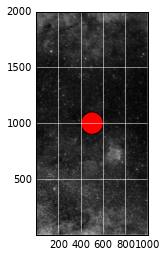

In [80]:
from astropy.wcs import WCS
ax = plt.subplot(projection=WCS(tile1.header))

ax.scatter(500, 1000, s=500, c='red', marker='o')
ax.imshow(image, origin='lower', cmap=plt.cm.gray)
ax.grid(color='white', ls='solid')